## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import project_path as pp
from cissir import visualization as viz
import numpy as np

viz.paper_style(line_cycler=False)

base_path = pp.module_path
plot_path = base_path/"plots"
res_path = base_path/"results"

In [2]:
res_df = pd.DataFrame()
for f in res_path.rglob("*.csv"):
    f_df = pd.read_csv(f, index_col=0)
    res_df = pd.concat([res_df, f_df])
if np.any(res_df.duplicated()):
    print("Warning, duplicated rows!")

res_df["si_db"] = - res_df["att_opt"]
res_df["si_db_full"] = - res_df["att_full"]

In [3]:
res_df.columns

Index(['att_tgt', 'opt', 'elapsed_time', 'att_opt', 'tx_loss', 'rx_loss',
       'att_full', 'phased', 'si_taps', 'num_beams', 'rx_sdr_err',
       'tx_sdr_err', 'att_sdr', 'tx_loss_sdr', 'rx_loss_sdr', 'rx_err',
       'tx_err', 'loss_tgt', 'si_db', 'si_db_full'],
      dtype='object')

In [4]:
res_df["si_taps"].unique()

array(['full', 1], dtype=object)

In [5]:
res_df["opt"].unique()

array(['sdp', 'socp', 'lonestar'], dtype=object)

In [6]:
tx_df = res_df.drop(columns="rx_loss")
tx_df["direction"] = "tx"
tx_df["cb_error"] = tx_df["tx_loss"]
rx_df = res_df.drop(columns="tx_loss")
rx_df["direction"] = "rx"
rx_df["cb_error"] = rx_df["rx_loss"]
bi_df = pd.concat([tx_df, rx_df]).reset_index().query("not opt == 'socp'")


In [7]:
xmin, xmax = -110,-68
ymin, ymax = -40, -8

markevry = 8
marksize = 6
dashes = ((1,0), (2,2))

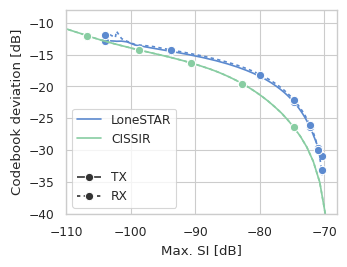

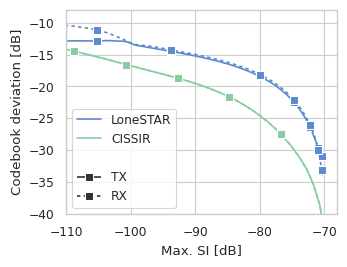

In [8]:
for prefix, phased, mrk in (("phased", True, "o"), ("taper", False, "s")):
    params = {"opt": "hue", "si_taps": 1, "phased": phased, "direction": "style"}
    query = []
    hue = style = None
    for k, p in params.items():
        if p == "hue":
            hue = k
        elif p == "style":
            style = k
        else:
            query.append(f"{k}=={p}")
     
    compare_plot = bi_df.query(" & ".join(query))
    
    fig, ax = plt.subplots()
    sns.lineplot(compare_plot, x="si_db", y="cb_error", style=style, hue=hue, hue_order=['lonestar', 'sdp'],
                 markers=[mrk, mrk], dashes=dashes, markevery=markevry, markersize=marksize, ax=ax)
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles[1:], ["LoneSTAR", "CISSIR", None, "TX", "RX"])
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    _ = plt.xlabel("Max. SI [dB]")
    _ = plt.ylabel("Codebook deviation [dB]")
    
    fig.savefig(plot_path/f"{prefix}_1tap_si.pdf", bbox_inches='tight')

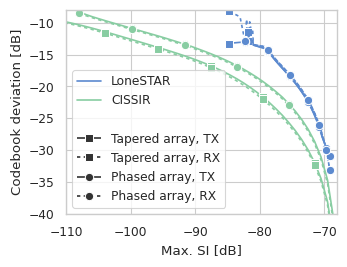

In [9]:
params = {"opt": "hue", "si_taps": 1, "phased": True, "direction": "style"}
query = []

full_df = bi_df.query("si_taps == 'full' or opt == 'lonestar'").reset_index()
full_df.loc[:, "ant_array"] = full_df.phased.map({True: "Phased array", False: "Tapered array"}) + ", " + full_df.direction.str.upper() 
compare_plot= full_df.query("opt != 'socp'")

ax = sns.lineplot(compare_plot, x="si_db_full", y="cb_error", style="ant_array", hue=hue, hue_order=['lonestar', 'sdp'],
                  style_order=["Tapered array, TX", "Tapered array, RX","Phased array, TX", "Phased array, RX",],
                  markers=["s", "s", "o", "o"], dashes=dashes + dashes, markevery=markevry, markersize=marksize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ["LoneSTAR", "CISSIR", None] + labels[4:] )

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

_ = plt.xlabel("Max. SI [dB]")
_ = plt.ylabel("Codebook deviation [dB]")

plt.savefig(plot_path/"full_si.pdf", bbox_inches='tight')

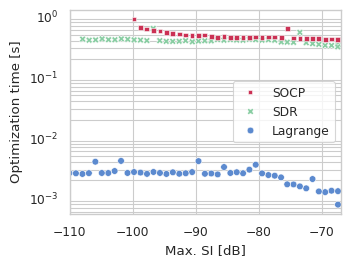

In [10]:
compare_plot = res_df.query("si_taps == 'full'").reset_index()
compare_plot.loc[(~compare_plot.phased) & (compare_plot.opt == "sdp"), "opt"] = "lagrange"
compare_plot["si_tgt"] = -compare_plot["att_tgt"]

ax = sns.scatterplot(compare_plot, x="si_db", y="elapsed_time", hue=hue, style=hue, hue_order=["socp", "sdp", "lagrange"],
                    palette=[viz.palette[n] for n in (3, 1, 0)])
ax.set(yscale="log")
ax.yaxis.grid(which="both")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["SOCP", "SDR", "Lagrange"])

plt.xlim(xmin, xmax + 1)

_ = plt.xlabel("Max. SI [dB]")
_ = plt.ylabel("Optimization time [s]")
plt.savefig(plot_path/"opt-time.pdf", bbox_inches='tight')